# Pseudo-label generator showcase

/home/khwstolle/projects/phd-dvps/unipercept/sources/unipercept/file_io.py:82: UserWarning: environment variable 'UP_CACHE' not defined! Using default: '~/.torch/unicore/cache'
  EnvironPathHandler(
/home/khwstolle/projects/phd-dvps/unipercept/sources/unipercept/file_io.py:89: UserWarning: environment variable 'UP_OUTPUT' not defined! Using default: './output'
  EnvironPathHandler(
/home/khwstolle/projects/phd-dvps/unipercept/sources/unipercept/file_io.py:96: UserWarning: environment variable 'UP_CONFIGS' not defined! Using default: './configs'
  EnvironPathHandler(
/home/khwstolle/projects/phd-dvps/unipercept/sources/unipercept/file_io.py:99: UserWarning: environment variable 'UP_SCRATCH' not defined! Using default: './scratch'
  EnvironPathHandler(


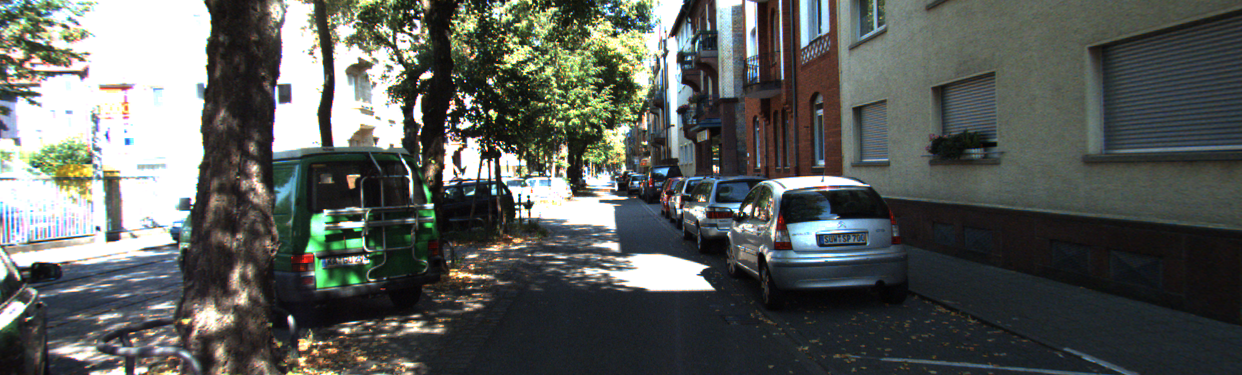

In [1]:
from IPython.display import display, HTML
import os

os.environ["UNICORE_DATASETS"] = os.path.expanduser("~/datasets")

import unipercept as up  # isort: skip

pseudogen = up.data.pseudolabeler.PseudoGenerator()
image = up.data.io.read_image("//datasets/kitti-step/testing/image_02/0000/000000.png")
info = up.data.sets.kitti_step.KITTISTEPDataset.read_info()

up.render.draw_image(image)

## Depth pseudo-label generation

### External model

We can generate depth labels using an external model.

Max. [m],Min. [m]
75.152,1.679


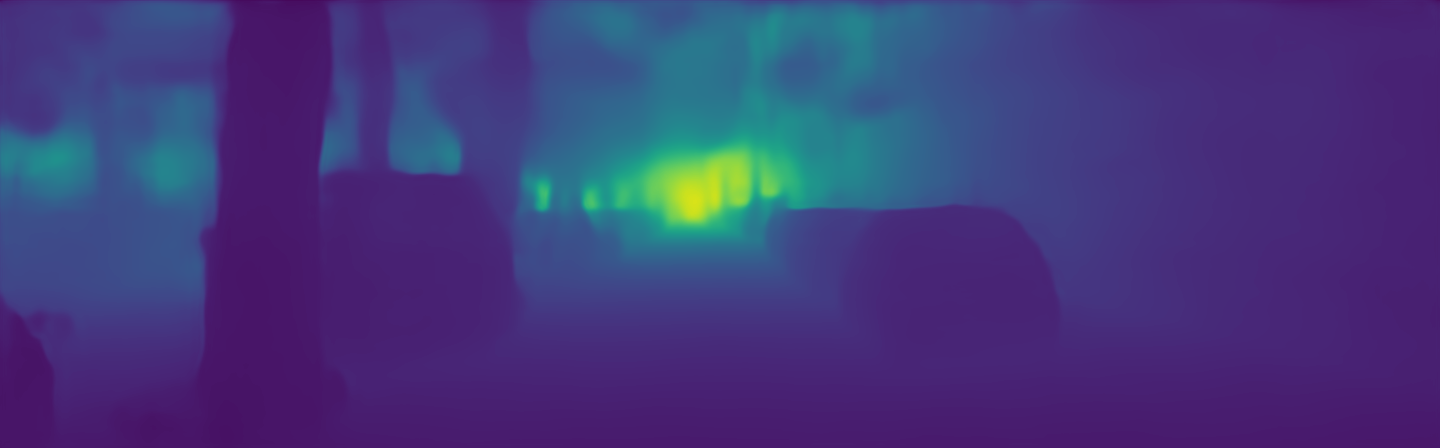

In [7]:
output_depth = pseudogen.run_depth_generator(image)
maximum_depth = output_depth.max()
minimum_depth = output_depth.min()

display(
    HTML(
        f"""
<table>
<thead>
    <tr><th>Max. [m]</th><th>Min. [m]</th></tr>
</thead>
<tbody>
    <tr><td>{maximum_depth:.3f}</td><td>{minimum_depth:.3f}</td></tr>
</tbody>
</table>
    """
    )
)

up.render.draw_image_depth(output_depth, info=info)

## Panoptic (proof of concept)

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on Cityscapes panoptic segmentation
processor = AutoImageProcessor.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-panoptic"
)
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-panoptic"
)

image = Image.open(
    up.file_io.get_local_path("//datasets/kitti-step/testing/image_02/0000/000000.png")
)
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_panoptic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
print(result.keys())

`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


[{'id': 1, 'label_id': 18, 'was_fused': False, 'score': 0.965724}, {'id': 2, 'label_id': 11, 'was_fused': False, 'score': 0.50091}, {'id': 3, 'label_id': 4, 'was_fused': False, 'score': 0.990605}, {'id': 4, 'label_id': 8, 'was_fused': False, 'score': 0.999861}, {'id': 5, 'label_id': 5, 'was_fused': False, 'score': 0.989217}, {'id': 6, 'label_id': 13, 'was_fused': False, 'score': 0.982798}, {'id': 7, 'label_id': 13, 'was_fused': False, 'score': 0.962684}, {'id': 8, 'label_id': 7, 'was_fused': False, 'score': 0.555067}, {'id': 9, 'label_id': 13, 'was_fused': False, 'score': 0.993858}, {'id': 10, 'label_id': 2, 'was_fused': False, 'score': 0.999911}, {'id': 11, 'label_id': 13, 'was_fused': False, 'score': 0.999971}, {'id': 12, 'label_id': 1, 'was_fused': False, 'score': 0.695226}, {'id': 13, 'label_id': 13, 'was_fused': False, 'score': 0.998866}, {'id': 14, 'label_id': 0, 'was_fused': False, 'score': 0.937101}, {'id': 15, 'label_id': 13, 'was_fused': False, 'score': 0.983081}, {'id': 16, 

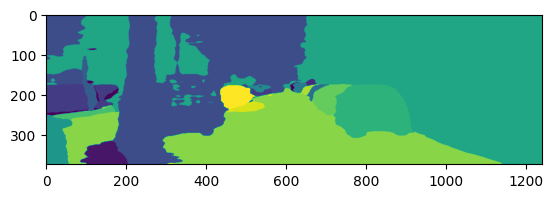

In [ ]:
import matplotlib.pyplot as plt

print(result["segments_info"])
plt.imshow(result["segmentation"])